# <center>Apple stock price prediction</center>

Historical apple stock price data were obtained from Apple Inc. (AAPL), Currency in USD at finance.yahoo.com [1].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import random
import sklearn
import math
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, acf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timezone, timedelta
import six
import sys
import pickle
sys.modules['sklearn.externals.six'] = six
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from yahoofinancials import YahooFinancials
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
############################################
# Define a function to load data from yahoo
############################################
def get_finance(ticker, start_date='2007-12-31'):
    """Download finance data from finance.yahoo.com"""
    data0=pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date=start_date, 
        end_date=datetime.today().strftime('%Y-%m-%d'), 
        time_interval='daily')[ticker]['prices'])
    data0['Date']=pd.to_datetime(data0['formatted_date'])
    data=data0.drop(columns=['date', 'formatted_date']).set_index('Date')
    return data
############################################
# Prediction functions
############################################
############################################
# Defind a function to calculate RMSE
############################################
def RMSE(prices):
    today_prices=pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:]
    predicted_prices=pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]
    return math.sqrt(mean_squared_error(today_prices, predicted_prices)) 
######################################
# Function to return RMSE against time
######################################
def RMSET(prices):
    return pd.Series([RMSE(prices[:n]) for n in range(2, len(prices))], 
                     index=[ele.datetime for ele in prices][1:-1])
######################################
# Function to tell rising precision
######################################
def precision(prices):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    dataframe['real_rise']=np.nan
    dataframe['predicted_rise']=np.nan
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        row['real_rise']=dataframe['open'].iloc[index_number+1]-row['open']
        row['predicted_rise']=dataframe['predicted'].iloc[index_number+1]-row['open']
    dataframe=dataframe.dropna()
    dataframe['bool_real_rise']=dataframe['real_rise'].apply(lambda x: 1 if x>0 else 0)
    dataframe['bool_predicted_rise']=dataframe['predicted_rise'].apply(lambda x: 1 if x>0 else 0)
    return precision_score(dataframe['bool_real_rise'], dataframe['bool_predicted_rise'])
#######################################
def plot_predicted_prices(prices, ax):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        if row['open']<dataframe['predicted'].iloc[index_number+1]:
            color='g'
        else:
            color='r'
        _=ax.plot([index, dataframe.index[index_number+1]], 
                  [row['open'], dataframe['predicted'].iloc[index_number+1]],
                  c=color)
########################################
def report(prices):
    dataframe=pd.DataFrame({'open': pd.Series([ele.open_price for ele in prices], 
                           index=[ele.datetime for ele in prices]).iloc[1:],
                           'predicted': pd.Series([ele.predicted_open_price for ele in prices], 
                               index=[ele.predicted_datetime for ele in prices]).iloc[:-1]})
    dataframe['real_rise']=np.nan
    dataframe['predicted_rise']=np.nan
    for index, row in dataframe.iterrows():
        if index==dataframe.index[-1]:break
        index_number=dataframe.index.get_loc(index)
        row['real_rise']=dataframe['open'].iloc[index_number+1]-row['open']
        row['predicted_rise']=dataframe['predicted'].iloc[index_number+1]-row['open']
    dataframe=dataframe.dropna()
    dataframe['bool_real_rise']=dataframe['real_rise'].apply(lambda x: 1 if x>0 else 0)
    dataframe['bool_predicted_rise']=dataframe['predicted_rise'].apply(lambda x: 1 if x>0 else 0)
    print('-----------------------------------------------------------------------')
    cm=confusion_matrix(dataframe['bool_real_rise'], dataframe['bool_predicted_rise'])
    conf_matr=pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T
    print(conf_matr)
    print('-----------------------------------------------------------------------')
    print(classification_report(dataframe['bool_real_rise'], dataframe['bool_predicted_rise']))
    print('-----------------------------------------------------------------------')
############################################
class Stock(object):
    def __init__(self, datetime, open_price, predicted_datetime, predicted_open_price):
        self.datetime=datetime
        self.open_price=open_price
        self.predicted_datetime=predicted_datetime
        self.predicted_open_price=predicted_open_price
################################
def sarimax_predict(y_train, y_test, params):
    """params=(p, d, q, P, D, Q, s, weekday, interval)"""
    p, d, q, P, D, Q, s, weekday, interval=params
    stock_prices=list()
    y_train_moving=y_train.copy()
    flag=False
    count=0
    for index, row in y_test.iterrows():
        y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
        if index.weekday()==weekday:
            flag=True
        if flag and count%interval==0:
            model_moving=sm.tsa.SARIMAX(y_train_moving, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
            y_prediction=model_moving.predict(start=len(y_train_moving.index), 
                                              end=len(y_train_moving.index)+interval)
            stock_prices.append(Stock(index, row[0], index+timedelta(interval), y_prediction.values[-1]))
        count+=1
    ###############################
    # return stock prices
    ###############################
    return stock_prices

/Users/yang/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


We firstly downloaded the data, then we selected open price as dependent variable for prediction.

In [2]:
apple0=get_finance('AAPL', start_date='2000-08-30')
##########################
# Delete Missing values
##########################
apple=apple0.dropna()
pd.DataFrame({' ' : ['Value'],
             'Original number of rows': [apple0.shape[0]],
             'Final number of rows': [apple.shape[0]],
             'Number of rows with NaN': [apple0.shape[0]-apple.shape[0]],
             'NaN rate': ['{:.2f}%'.format((apple0.shape[0]-apple.shape[0])/apple0.shape[0]*100)]}).set_index(' ').T

,Value
Original number of rows,5194
Final number of rows,5194
Number of rows with NaN,0
NaN rate,0.00%


In [3]:
# Describe of the data set.
apple.tail()

,high,low,open,close,volume,adjclose
Date,,,,,,
2021-04-19,135.470001,133.339996,133.509995,134.839996,94264200,134.839996
2021-04-20,135.529999,131.809998,135.020004,133.110001,94812300,133.110001
2021-04-21,133.750000,131.300003,132.360001,133.500000,68847100,133.500000
2021-04-22,134.149994,131.410004,133.039993,131.940002,84566500,131.940002
2021-04-23,135.119995,132.160004,132.160004,134.320007,78657500,134.320007


We focus on open prices as dependent variable, and subset the open column.

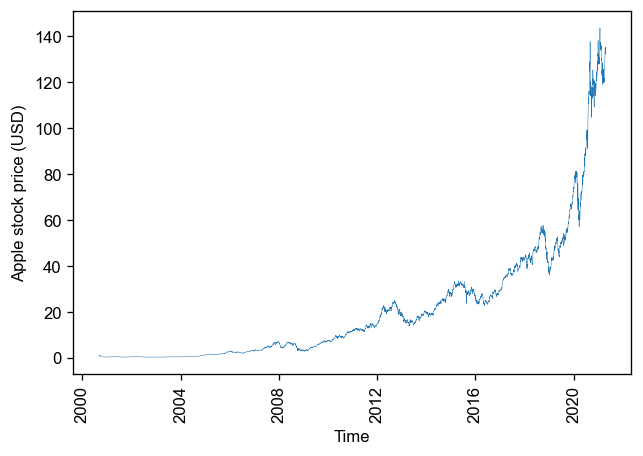

In [4]:
fig, ax=plt.subplots(1, 1)
ax.plot(apple[['open']], linewidth=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('Apple stock price (USD)')
plt.xticks(rotation=90)
plt.show()

In [5]:
#############################################################
# Test whether apple stock price time series is random walk
#############################################################
adfuller_result=adfuller(apple['open'].diff().dropna())
pd.DataFrame({' ': ['Value'], 'ADF Statistic:': ['{:.3f}'.format(adfuller_result[0])],
             'p-value:': ['{:.9f}'.format(adfuller_result[1])],
              'Critical Values 1%:': ['{:.3f}'.format(list(adfuller_result[4].values())[0])],
              'Critical Values 5%:': ['{:.3f}'.format(list(adfuller_result[4].values())[1])],
              'Critical Values 10%:': ['{:.3f}'.format(list(adfuller_result[4].values())[2])]
             }).set_index(' ').T

,Value
ADF Statistic:,-12.253
p-value:,0.000000000
Critical Values 1%:,-3.432
Critical Values 5%:,-2.862
Critical Values 10%:,-2.567


With an extremely small p-value from an Augmented Dickey-Fuller test on the first order difference (the return) of the apple stock price time series, we can reject the null hypothesis of random walk, and conclude that the time series is not a random walk. It is possible to predict the apple stock price!

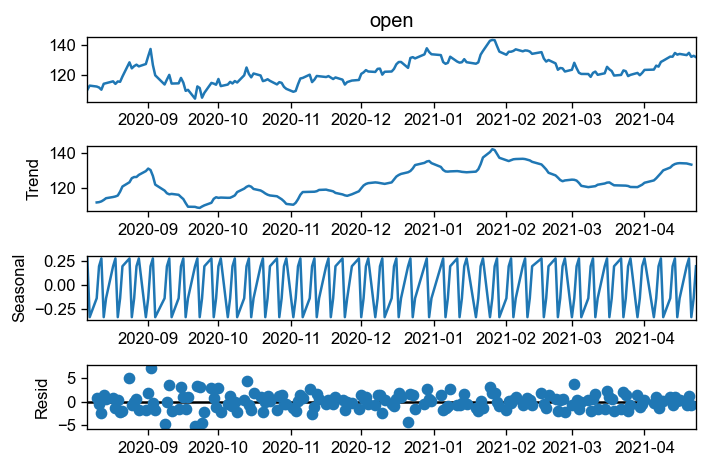

In [6]:
#####################################################################
# Decompose the apple stock price time series
#####################################################################
seasonal_decompose(apple['open'].iloc[-180:], model='linear', period=4).plot()
plt.show()

It seems that the apple stock price has a seasonal component. It may due to a mean reversion: when the price gets higher, people want to sell, causing the price go lower, and then people want to buy, causing the price higher, again and again. The goal of this project is using this mean reversion to make the model profitable (to make prediction by the behavior of apple stock price itself).

Next, we are going to find out if the apple stock price return time series is stationary. 

In [7]:
#########################################################
# Use kpss to tell if apple stock return is stationary
#########################################################
pd.DataFrame({' ': ['p-value'], 
             '1 order of difference': [kpss(apple['open'].diff().dropna())[1]],
             '2 order of difference': [kpss(apple['open'].diff().dropna().diff().dropna())[1]]}).set_index(' ').T

,p-value
1 order of difference,0.01
2 order of difference,0.10


We can see that the apple stock return is not stationary. However, second order of difference (the difference of the return) makes the apple stock price stationary.

We will use ACF and PACF to tell which AR or MA model can fit the apple stock price time series.

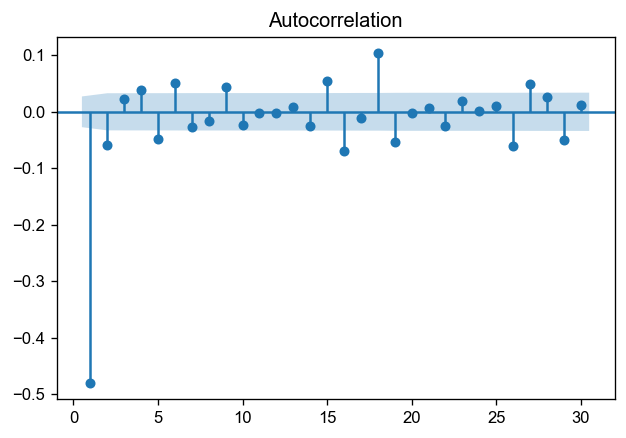

In [8]:
###################################################################################################################
# Autocorrelation investigation for apple stock price (95% confidence interval)
###################################################################################################################
_=plot_acf(apple['open'].diff().dropna().diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

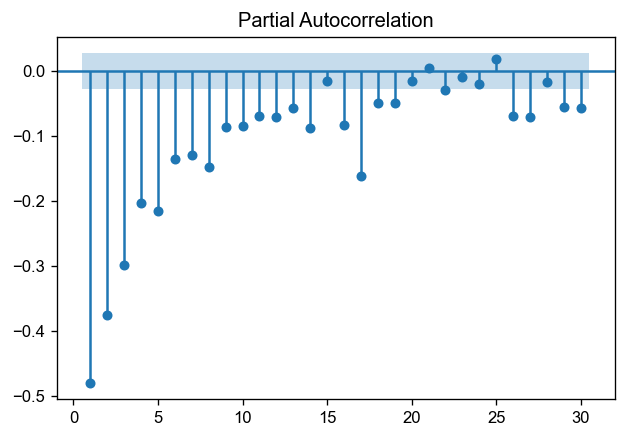

In [9]:
_=plot_pacf(apple['open'].diff().dropna().diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

The ACF cuts off after lag 1, and PACF tails off, indicating a MA(1) model ($q$=1). Because the second order of difference can make the apple stock price stationary, the order of differencing $d$=2. $p$ should be zero but we are going to do a hyperparameter optimization to further determine the values of $p$, $d$, and $q$. 

We are going to use an Autoregressive Integrated Moving Averages (ARIMA) model to fit and predict the apple stock prices. ARIMA is well-known for forecasting stocks and financial market fluctuations, and data scientists and researchers have been utilizing ARIMA model to predict the price of gold [1,6]. Without helps of exogenous variables, we will see how good our prediction will be.

The goal of this project is to be profitable. We want this model be able to tell us, in a certain time window, is the price going up or down. The model is going to be indicative for us whether we should bull the market or do short sale for the stock within several business days. Long-term prediction is not in the scope of this project.

In [10]:
####################################################
# Fill missing dates
####################################################
Y=apple[['open']].loc[pd.to_datetime("2015", format='%Y'):]
Y=Y.resample('D').ffill()
###############################################
# Train-test split
###############################################
y_train=Y.loc[Y.index<pd.to_datetime("2020", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2020", format='%Y')]
print(y_train.shape)
print(y_test.shape)

(1825, 1)
(479, 1)


In [18]:
##########################################################################################
# Use train set to do cross validation hyperparameter tunning - random search
##########################################################################################
random.seed(6)
#################################################
# params=(p, d, q, P, D, Q, s, weekday, interval)
#################################################
PARAMS=list(set([(
    random.sample([1, 2], 1)[0], random.sample([1, 2], 1)[0], 
    random.sample([1, 2], 1)[0], random.sample([0, 1, 2, 3], 1)[0], 
    random.sample([0, 1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0],
    random.sample([2, 3, 4, 5, 6, 7, 8, 9], 1)[0],
    random.sample([0, 1, 2, 3, 4, 5, 6], 1)[0], 
    random.sample([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 1)[0]) for i in range(1000)]))
results=pd.DataFrame(columns=['params', 'RMSE list', 'mean RMSE', 'precision list', 'mean precision'])
index=0
for params in tqdm.tqdm(PARAMS):
    try:
        RMSE_list=[]
        precision_list=[]
        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(y_train):
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            prices=sarimax_predict(y_train_train, y_train_test, params=params)
            RMSE_list.append(RMSE(prices))
            precision_list.append(precision(prices))        
        results=results.append(pd.DataFrame({'params': [params], 
                    'RMSE list': [['{:.2f}'.format(ele) for ele in RMSE_list]],
                    'mean RMSE': [np.mean(RMSE_list)],
                    'precision list': [['{:.2f}'.format(ele) for ele in precision_list]],
                    'mean precision': [np.mean(precision_list)]}, index=[index]))
        index+=1
    except:
        pass
#####################################################
results.sort_values(by=['mean precision', 'mean RMSE'], ascending=[False, True]).head()

100%|██████████| 1000/1000 [116:14:42<00:00, 418.48s/it]    


,params,RMSE list,mean RMSE,precision list,mean precision
157,"(2, 1, 1, 0, 3, 3, 7, 5, 14)","[2.81, 1.92, 4.09, 3.75, 4.47]",3.406669,"[0.56, 0.75, 0.64, 0.80, 1.00]",0.748384
178,"(2, 2, 1, 0, 1, 2, 7, 5, 14)","[1.58, 1.28, 2.07, 2.98, 2.00]",1.981714,"[1.00, 0.72, 0.61, 0.62, 0.78]",0.745299
245,"(1, 2, 1, 1, 3, 1, 6, 1, 11)","[3.08, 2.43, 4.24, 3.53, 4.50]",3.557154,"[0.85, 0.57, 0.57, 0.75, 0.88]",0.722802
86,"(2, 2, 1, 2, 3, 3, 8, 2, 13)","[3.38, 2.63, 4.50, 4.54, 5.44]",4.097363,"[0.50, 0.86, 0.54, 0.89, 0.82]",0.720535
142,"(2, 2, 2, 1, 3, 2, 9, 6, 14)","[3.68, 2.30, 5.25, 4.56, 5.55]",4.270595,"[0.50, 0.75, 0.70, 0.70, 0.92]",0.714615


Prediction precision is 61.29%
-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             19               1              12              0
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.61      0.95      0.75        20

    accuracy                           0.59        32
   macro avg       0.31      0.47      0.37        32
weighted avg       0.38      0.59      0.47        32

-----------------------------------------------------------------------


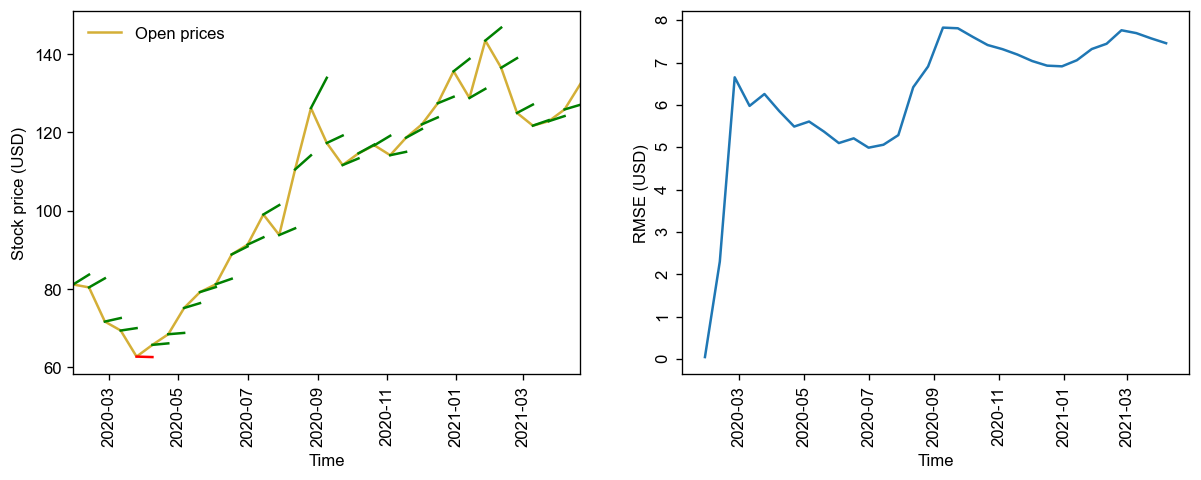

In [12]:
######################################
# Apply the best model on test data
######################################
test_prices_sarimax=sarimax_predict(y_train, y_test, params=(2, 2, 1, 0, 1, 2, 7, 5, 14))
print('Prediction precision is {:.2f}%'.format(precision(test_prices_sarimax)*100))
##############################################
# Plot predict result on test set
##############################################
report(test_prices_sarimax)
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
open_prices=pd.Series([ele.open_price for ele in test_prices_sarimax], 
                      index=[ele.datetime for ele in test_prices_sarimax]).iloc[1:]
predicted_prices=pd.Series([ele.predicted_open_price for ele in test_prices_sarimax], 
                           index=[ele.predicted_datetime for ele in test_prices_sarimax]).iloc[:-1]
_=ax1.plot(open_prices,
        label='Open prices', c=(212/255, 175/255, 55/255))
_=plot_predicted_prices(test_prices_sarimax, ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
_=ax1.set_xlabel('Time')
_=ax1.set_ylabel('Stock price (USD)')
_=ax1.legend(frameon=False)
_=ax1.set_xlim([open_prices.index[0], open_prices.index[-1]])
_=ax2.plot(RMSET(test_prices_sarimax))
_=ax2.tick_params(labelrotation=90)
_=ax2.set_ylabel('RMSE (USD)')
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
_=ax2.set_xlabel('Time')
plt.show()

### References

[1] https://finance.yahoo.com

